# 12 Generative deep learning

## 12.2 DeepDream

- DeepDream is an artistic image-modification technique that uses the representations learned by convolutional neural networks
- DeepDream algorithm
  - doing gradient ascent on the input to the convnet in order to maximize the activation of a specific filter in an upper layer of the convnet
    - With DeepDream, you try to maximize the activation of entire layers rather than that of a specific filter, thus mixing together visualizations of large numbers of features at once.
    - You start not from blank, slightly noisy input, but rather from an existing image—thus the resulting effects latch on to preexisting visual patterns, distorting elements of the image in a somewhat artistic fashion.
    - The input images are processed at different scales (called octaves), which improves the quality of the visualizations.

### 12.2.1 Implementing DeepDream in Keras

450560/440742 [==============================] - 0s 0us/step


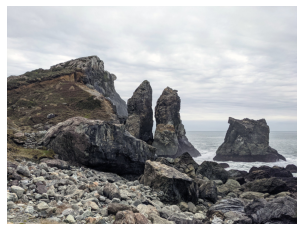

In [2]:
# Listing 12.9 Fetching the test image
from tensorflow import keras 
import matplotlib.pyplot as plt
 
base_image_path = keras.utils.get_file("coast.jpg", origin="https://img-datasets.s3.amazonaws.com/coast.jpg")
 
plt.axis("off")
plt.imshow(keras.utils.load_img(base_image_path))

In [3]:
# Listing 12.10 Instantiating a pretrained InceptionV3 model
from tensorflow.keras.applications import inception_v3
model = inception_v3.InceptionV3(weights="imagenet", include_top=False)

87924736/87910968 [==============================] - 1s 0us/step


In [4]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                    

- use pretrained convnet to create a feature exactor model that returns the activations of the various intermediate layers

In [5]:
# Listing 12.11 Configuring the contribution of each layer to the DeepDream loss
layer_settings = {
    "mixed4": 1.0,
    "mixed5": 1.5,
    "mixed6": 2.0,
    "mixed7": 2.5,
}
outputs_dict = dict(
    [
     (layer.name, layer.output)
     for layer in [model.get_layer(name)for name in layer_settings.keys()]]

)
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

In [6]:
# Listing 12.12 The DeepDream loss
import tensorflow as tf

def compute_loss(input_image):
  features = feature_extractor(input_image)
  loss = tf.zeros(shape=())
  for name in features.keys():
    coeff = layer_settings[name]
    activation = features[name]
    loss += coeff * tf.reduce_mean(tf.square(activation[:, 2:-2, 2:-2, :]))
  return loss

In [7]:
# The DeepDream gradient ascent process
@tf.function
def gradient_ascent_step(image, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = compute_loss(image)
    grads = tape.gradient(loss, image)
    grads = tf.math.l2_normalize(grads)
    image += learning_rate * grads
    return loss, image


def gradient_ascent_loop(image, iterations, learning_rate, max_loss=None):
    for i in range(iterations):
        loss, image = gradient_ascent_step(image, learning_rate)
        if max_loss is not None and loss > max_loss:
            break
        print(f"... Loss value at step {i}: {loss:.2f}")
    return image

In [8]:
step = 20.
num_octave = 3
octave_scale = 1.4
iterations = 30
max_loss = 15.

In [9]:
# Image processing utilities

import numpy as np

def preprocess_image(image_path):
    img = keras.utils.load_img(image_path)
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = keras.applications.inception_v3.preprocess_input(img)
    return img

def deprocess_image(img):
    img = img.reshape((img.shape[1], img.shape[2], 3))
    img /= 2.0
    img += 0.5
    img *= 255.
    img = np.clip(img, 0, 255).astype("uint8")
    return img

In [10]:
# Listing 12.15 Running gradient ascent over multiple successive "octaves"
original_img = preprocess_image(base_image_path)
original_shape = original_img.shape[1:3]

successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]

shrunk_original_img = tf.image.resize(original_img, successive_shapes[0])

img = tf.identity(original_img)
for i, shape in enumerate(successive_shapes):
    print(f"Processing octave {i} with shape {shape}")
    img = tf.image.resize(img, shape)
    img = gradient_ascent_loop(
        img, iterations=iterations, learning_rate=step, max_loss=max_loss
    )
    upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape)
    same_size_original = tf.image.resize(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img
    img += lost_detail
    shrunk_original_img = tf.image.resize(original_img, shape)

keras.utils.save_img("dream.png", deprocess_image(img.numpy()))

Processing octave 0 with shape (459, 612)
... Loss value at step 0: 0.80
... Loss value at step 1: 1.07
... Loss value at step 2: 1.44
... Loss value at step 3: 1.82
... Loss value at step 4: 2.15
... Loss value at step 5: 2.50
... Loss value at step 6: 2.85
... Loss value at step 7: 3.22
... Loss value at step 8: 3.53
... Loss value at step 9: 3.89
... Loss value at step 10: 4.25
... Loss value at step 11: 4.59
... Loss value at step 12: 4.93
... Loss value at step 13: 5.30
... Loss value at step 14: 5.62
... Loss value at step 15: 5.98
... Loss value at step 16: 6.31
... Loss value at step 17: 6.66
... Loss value at step 18: 6.98
... Loss value at step 19: 7.29
... Loss value at step 20: 7.63
... Loss value at step 21: 7.96
... Loss value at step 22: 8.23
... Loss value at step 23: 8.51
... Loss value at step 24: 8.81
... Loss value at step 25: 9.10
... Loss value at step 26: 9.32
... Loss value at step 27: 9.64
... Loss value at step 28: 9.90
... Loss value at step 29: 10.17
Process

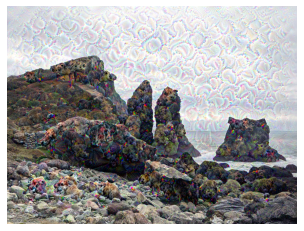

In [11]:
plt.axis("off")
plt.imshow(deprocess_image(img.numpy()))

---